<a href="https://colab.research.google.com/github/Gasca78/Modelo_Clasificador_de_Digitos_NMIST/blob/main/Clasificador_de_Digitos_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Portafolio: Clasificador de Dígitos MNIST con PyTorch

**Oswaldo Gasca**

**Objetivo:** Este proyecto implementa un clasificador de imágenes para el dataset MNIST. Se construye y entrena una Red Neuronal Densa (DNN) con PyTorch y se visualiza qué píxeles son más importantes para el modelo a la hora de tomar una decisión.

In [1]:
# ===================================================================
# 1. Carga de Librerías y Definición de Funciones
# ===================================================================

# Importación de librerías esenciales
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

# ----------------- Definición de la Red Neuronal -----------------
class DNN(nn.Module):
    def __init__(self, n, actfun='relu', p=0.0):
        super(DNN, self).__init__()
        self.L = len(n) - 1
        if actfun.lower() == 'sigmoid':
            self.actfun = nn.Sigmoid
        elif actfun.lower() == 'tanh':
            self.actfun = nn.Tanh
        else:
            self.actfun = nn.ReLU
        layers = list()
        for i in range(self.L - 1):
            layers.append((f'l_{i+1}', nn.Linear(n[i], n[i+1])))
            layers.append((f'actfun_{i+1}', self.actfun()))
            layers.append((f'dropout_{i+1}', nn.Dropout(p)))
        layers.append((f'l_{self.L}', nn.Linear(n[-2], n[-1])))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.layers(x)

# ----------------- Funciones Auxiliares -----------------
def err_vs_iter(values):
    """Grafica la curva de pérdida durante el entrenamiento."""
    plt.plot(values)
    plt.xlabel('Iteraciones')
    plt.ylabel('Error (Loss)')
    plt.title('Curva de Aprendizaje: Error vs. Iteraciones')
    plt.show()

def train_model(model, optimizer, criterion, x_train, y_train, x_test, y_test, max_iteration, divisor):
    """Entrena el modelo de red neuronal."""
    train_losses = []
    model.train() # Poner el modelo en modo de entrenamiento
    for iter in range(max_iteration):
        # Forward pass
        output_train = model(x_train)
        loss_train = criterion(output_train, y_train)
        train_losses.append(loss_train.item())
        # Backward pass
        loss_train.backward()
        # Actualización de pesos
        optimizer.step()
        optimizer.zero_grad()
        if (iter + 1) % divisor == 0:
            print(f"Iteracion {iter+1}/{max_iteration}, Train loss = {loss_train.item():.4f}")
    # Evaluación final con datos de prueba
    with torch.no_grad():
        model.eval() # Poner el modelo en modo de evaluación
        y_hat_test = model(x_test)
        loss_test = criterion(y_hat_test, y_test)
    return train_losses, loss_test.item()

def evaluacion(x, y, title):
    """Calcula y muestra la precisión del modelo en un conjunto de datos."""
    with torch.no_grad():
        model.eval()
        n_samples = len(y)
        pred = model(x)
        y_pred = torch.max(pred, dim=1)[1]
        print(f'{title} accuracy = {100 * (y == y_pred).sum().item() / n_samples:.2f}%')

## 2. Carga y Exploración del Dataset MNIST

Se utiliza la librería `torchvision` para descargar y cargar automáticamente el dataset MNIST. Luego, se visualiza una imagen de ejemplo para verificar que los datos se han cargado correctamente.

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.63MB/s]


Forma del tensor de la imagen: torch.Size([1, 28, 28])
Etiqueta de la imagen: 5


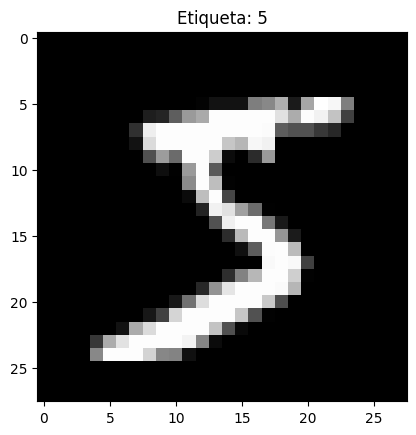

In [2]:
# Cargar el dataset de entrenamiento y prueba de MNIST
train_set = torchvision.datasets.MNIST(root='./Data', train=True, transform=transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST(root='./Data', train=False, transform=transforms.ToTensor())

# Accedemos a una imagen de ejemplo
image, label = train_set[0]
print(f"Forma del tensor de la imagen: {image.shape}")
print(f"Etiqueta de la imagen: {label}")

# Visualizar la imagen de ejemplo
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Etiqueta: {label}')
plt.show()

## 3. Preparación de Datos para el Modelo

Las imágenes de 28x28 píxeles deben ser transformadas en un formato que la red neuronal densa pueda procesar. Para ello, cada imagen se "aplana" en un vector de una sola dimensión de 784 elementos (28 * 28 = 784).

In [3]:
# Aplanar las imágenes a vectores de 784 y convertir a tensores float
X_train = train_set.data.float().view(-1, 28*28)
y_train = train_set.targets

X_test = test_set.data.float().view(-1, 28*28)
y_test = test_set.targets

print(f"Dimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")

Dimensiones de X_train: torch.Size([60000, 784])
Dimensiones de y_train: torch.Size([60000])


## 4. Modelado y Entrenamiento

Se define la arquitectura del modelo, los hiperparámetros y se procede con el entrenamiento.

- **Arquitectura:** Red Neuronal Densa con una capa de entrada (784 neuronas), una capa oculta (20 neuronas, ReLU) y una capa de salida (10 neuronas).
- **Función de Pérdida:** `CrossEntropyLoss`, adecuada para clasificación multiclase.
- **Optimizador:** `Adam`.
- **Hiperparámetros:** `learning_rate = 1e-3`, `max_iter = 5000`.

In [4]:
# Definimos las dimensiones del modelo
input_dim = 28 * 28
output_dim = 10
model = DNN(n=[input_dim, 20, output_dim], actfun='relu')

# Hiperparámetros
learning_rate = 1e-3
max_iter = 5000
divisor = 500

# Optimizador y Función de Pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Proceso de optimización
loss_train, loss_test = train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, max_iter, divisor)

Iteracion 500/5000, Train loss = 0.2529
Iteracion 1000/5000, Train loss = 0.1744
Iteracion 1500/5000, Train loss = 0.1468
Iteracion 2000/5000, Train loss = 0.1346
Iteracion 2500/5000, Train loss = 0.1262
Iteracion 3000/5000, Train loss = 0.1224
Iteracion 3500/5000, Train loss = 0.1175
Iteracion 4000/5000, Train loss = 0.1148
Iteracion 4500/5000, Train loss = 0.1142
Iteracion 5000/5000, Train loss = 0.1121


## 5. Evaluación de Resultados

Una vez finalizado el entrenamiento, se evalúa el rendimiento final del modelo midiendo la precisión (accuracy) tanto en el conjunto de datos de entrenamiento como en el de prueba.

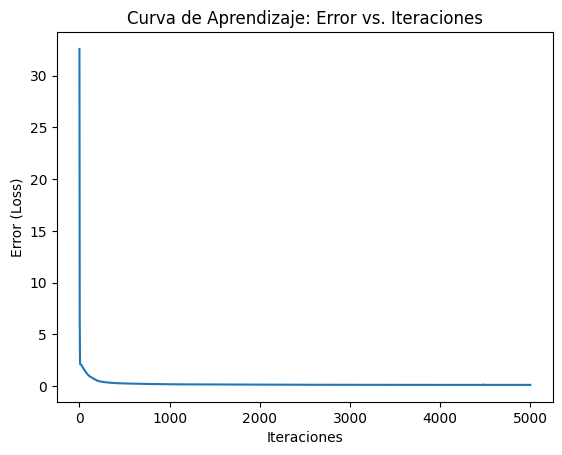

Test error final (loss): 0.44097915291786194

--- Precisión Final del Modelo ---
Train accuracy = 96.70%
Test accuracy = 92.59%


In [5]:
# Graficar la curva de aprendizaje
err_vs_iter(loss_train)
print(f'Test error final (loss): {loss_test}')

# Obtenemos la precisión (accuracy) final para los datos de entrenamiento y prueba
print("\n--- Precisión Final del Modelo ---")
evaluacion(X_train, y_train, 'Train')
evaluacion(X_test, y_test, 'Test')

## 6. Interpretación del Modelo: ¿Qué Píxeles son Importantes?

Para entender qué aprendió el modelo, podemos visualizar la importancia de cada píxel de entrada. Esto se logra extrayendo los pesos de la primera capa de la red. Un peso alto (en valor absoluto) significa que el píxel correspondiente es muy influyente en la decisión del modelo.

El siguiente mapa de calor muestra que el modelo aprendió a prestar atención principalmente a la región central, donde se dibujan los dígitos, y a ignorar los bordes.

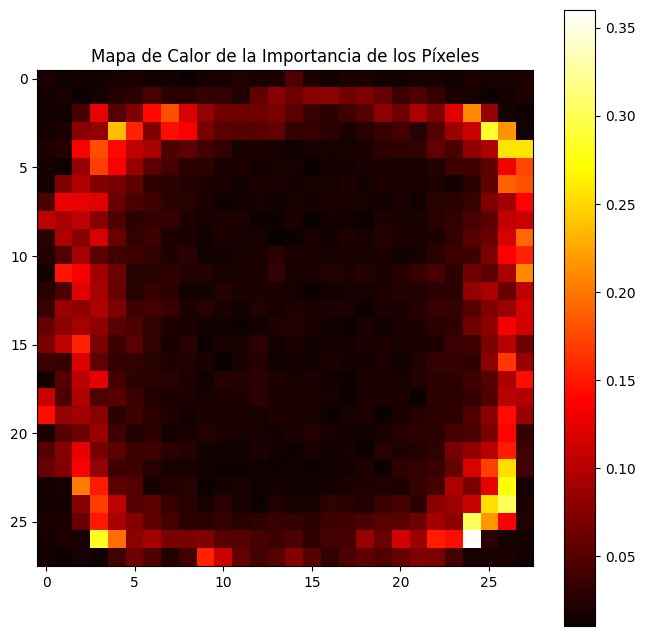

In [6]:
# Extraemos los pesos de la primera capa (entrada -> oculta)
pesos = model.layers.l_1.weight.data

# Calculamos la importancia de cada píxel promediando el valor absoluto de sus pesos
sig_pix = torch.abs(pesos).mean(dim=0)

# Reorganizamos el vector de 784 a una matriz de 28x28 para visualizarlo
sig_pix = sig_pix.view(28, 28)

# Graficamos el mapa de calor
plt.figure(figsize=(8, 8))
plt.imshow(sig_pix.cpu(), cmap='hot')
plt.title("Mapa de Calor de la Importancia de los Píxeles")
plt.colorbar()
plt.show()